# Music machine learning - Adversarial learning

### Author: Philippe Esling (esling@ircam.fr)

Generative adversarial networks (GANs) are neural networks that generate material, such as images, music, speech, or text, that is similar to what humans produce.

In this course we will cover
1. The global principle of [adversarial learning](#adversarial)
2. How to train your own GAN on a [toy dataset](#toy)
3. A practical example on [MNIST](#mnist) using PyTorch

<a id="adversarial"></a>
## Adversarial learning

This is the code used in first example of the article [Generative Adversarial Networks: Build Your First Models](https://realpython.com/generative-adversarial-networks/) on Real Python.

In [1]:
import torch
from torch import nn
import math
import matplotlib.pyplot as plt
from helper_plot import hdr_plot_style
hdr_plot_style()

Generative adversarial networks (GANs) are machine learning systems that can learn to mimic a given distribution of data. GANs consist of two neural networks, one trained to *generate* data and the other trained to *discriminate* fake data from real data (hence the “adversarial” nature of the model).

GANs require to define two neural networks, one called the *generator* and the other called the *discriminator*. The role of the generator is to estimate the probability distribution of the real samples in order to provide generated samples resembling real data. The discriminator, in turn, is trained to estimate the probability that a given sample came from the real data rather than being provided by the generator.

These two networks define a *zero-sum game* as they are trained to compete with each other: the generator tries to get better at fooling the discriminator, while the discriminator tries to get better at identifying generated samples.

## Training GANs on a toy dataset

To understand how GAN training works, consider a toy example with a dataset composed of two-dimensional samples $(x_{1}, x_{2})$, with $x_{1}$ in the interval from $0$ to $2\pi$ and $x_{2} = sin(x_{1})$, as illustrated in the following 

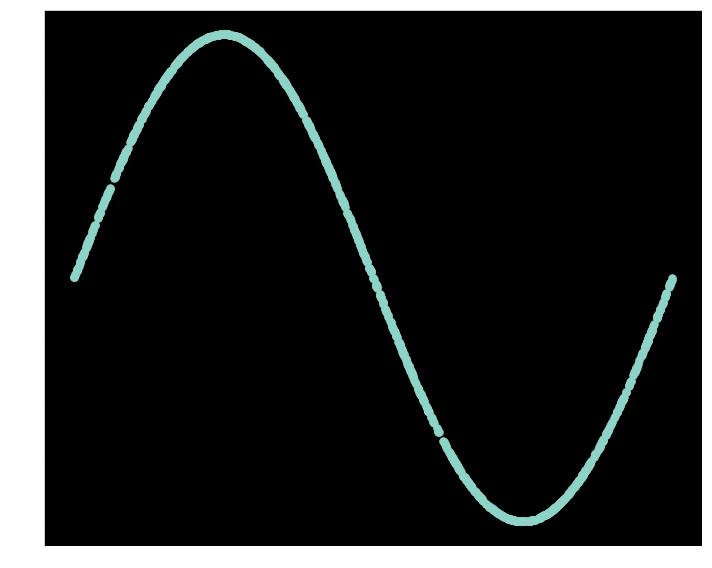

In [2]:
train_data_length = 1024
train_data = torch.zeros((train_data_length,2))
train_data[:,0] = 2*math.pi*torch.rand(train_data_length)
train_data[:,1] = torch.sin(train_data[:,0])
train_labels = torch.zeros(train_data_length)
trainset = [(train_data[i], train_labels[i]) for i in range(train_data_length)]
plt.figure(figsize=(10,8))
plt.plot(train_data[:, 0], train_data[:, 1], '.')
plt.tight_layout()

As usual, we need to define a `DataLoader` that will provide us with the training data in different batches.

In [4]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

First, we define the generator, which is fed with random data from a latent space. Its role is to generate data resembling the real samples. In this example, you have a two-dimensional latent space, so that the generator is fed with random $(z_{1}, z_{2})$ pairs and is required to transform them so that they resemble the real samples.

We can define any type of network in the generator, given that it has sufficient complexity to generate the underlying type of data.

In [19]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2),            
        )

    def forward(self, x):
        output = self.model(x)
        return output

In [20]:
generator = Generator()

In turn, the discriminator is fed with either real samples from the training dataset or generated samples provided by the generator. Its role will be to estimate the probability that the input belongs to the real dataset or is a generated one. The training is performed so that the discriminator outputs 1 when it is fed a real sample and 0 when it is fed a generated sample. Again, we can choose any architecture of our liking for this network.

In [21]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        output = self.model(x)
        return output

In [22]:
discriminator = Discriminator()

We can now define our training hyper-parameters that will condition the learning procedure.

In [27]:
lr = 0.001
num_epochs = 600
loss_function = nn.BCELoss()
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

The training procedure is defined as follows

In [28]:
loss_d = torch.zeros(int(num_epochs / 10))
loss_g = torch.zeros(int(num_epochs / 10))
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        
        ######################
        # YOUR CODE GOES HERE
        ######################
    
        ######################
        # Solution
        # Generate data from random latent positions
        latent_space_samples = torch.randn((batch_size, 2))
        generated_samples = generator(latent_space_samples)
        # Prepare the labels for training
        real_samples_labels = torch.ones((batch_size, 1))
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 2))

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()
        ######################

    # Show loss
    if epoch % 10 == 0 and n == batch_size - 1:
        loss_d[int(epoch / 10)] = loss_discriminator
        loss_g[int(epoch / 10)] = loss_generator

If we look at the evolution of different losses, we can clearly see the competing nature of both networks

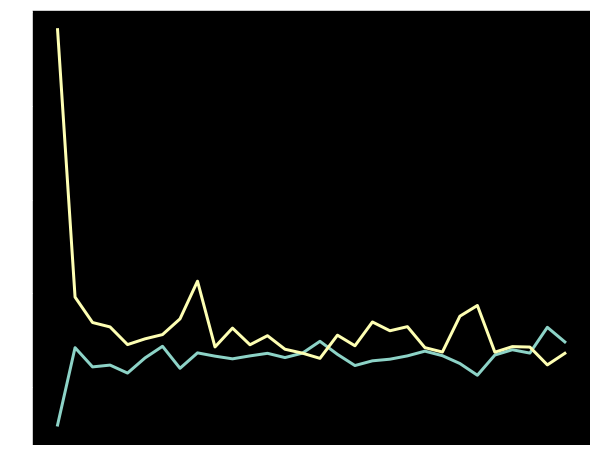

In [25]:
plt.figure(figsize=(10,8))
plt.plot(loss_d.detach())
plt.plot(loss_g.detach())

Now, we can visualize the samples that can be generated by drawing some random latent positions.

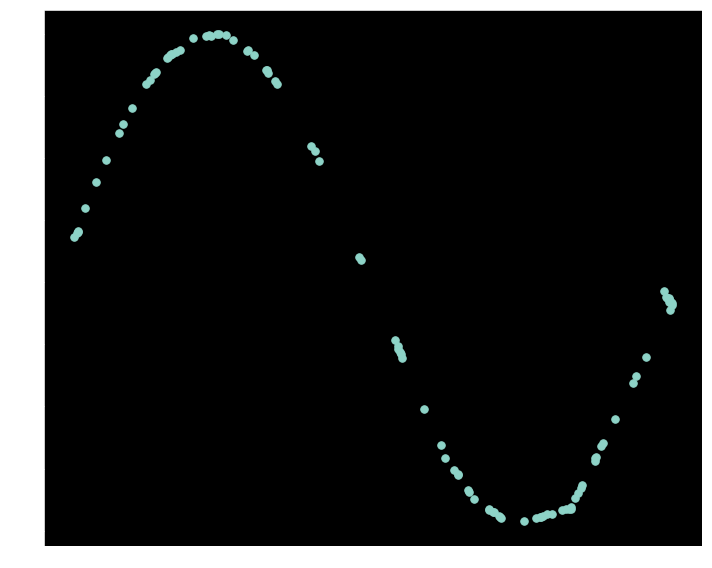

In [31]:
latent_space_samples = torch.randn(100, 2)
generated_samples = generator(latent_space_samples)
generated_samples = generated_samples.detach()
plt.figure(figsize=(10,8))
plt.plot(generated_samples[:,0], generated_samples[:,1], '.')
plt.tight_layout()

As we can see, the randomly generated points closely follow the original distribution.

## Handwritten digits generator with GAN

Generative adversarial networks can also generate high-dimensional samples such as images. In this example, we are going to define a GAN to generate images of handwritten digits. For that, we will train the models using the infamous MNIST dataset. 

Again, we are going to make use of `torch` and `torchvision` . Notably, we will use `transforms` to obtain the training data and perform image conversions.

In [20]:
import torch
from torch import nn, optim
import torchvision
import torchvision.transforms as transforms
import math
import matplotlib.pyplot as plt
import os

Since this example uses images in the training set, the models need to be more complex, with a larger number of parameters. This makes the training process slower, taking about two minutes per epoch when running on CPU. To reduce the training time, you can use a GPU to train the model if you have one available. The following piece of code allows to automatically select the best device available on your system.

In [21]:
device = ''
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

### Preparing the training data

The MNIST dataset consists of 28 × 28 pixel grayscale images of handwritten digits from 0 to 9. To use them with PyTorch, we need to convert them to Tensors. Also, in order to ensure adequate learning, it is always best to normalize the data. This is were we make use of `torchvision.transforms` in order to perfom thesse automatically while loading the data.

In [22]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

Now, as usual, we can load both the *training* and *testing* data with the datasets objects

In [23]:
batch_size = 32
# Load the training set
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# Create a batched data loader
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

Here we plot some examples of the train set, to better understand the underlying data that we are working with.

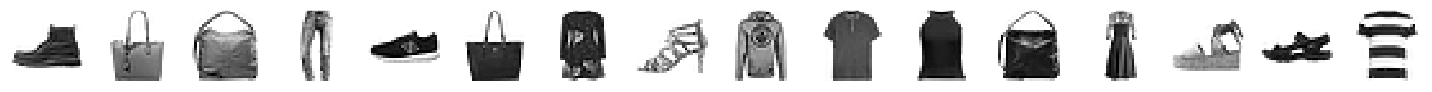

In [24]:
fig = plt.figure(figsize=(20,5))
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(1, 16, i+1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()    

### Implementing the discriminator and generator

Here, we are going to first define our *discriminator*. In our case, we will use an MLP, that will be responsible for receiving the images and trying to find which images are fake. The model is defined as follows 

In [25]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        ######################
        # YOUR CODE GOES HERE
        ######################
    
        ######################
        # Solution
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
        ######################

    def forward(self, x):
        x = x.view(-1, 784)
        output = self.model(x)
        return output

To input the image coefficients into the MLP neural network, you vectorize them so that the neural network receives vectors with 784 coefficients. The vectorization occurs in the first line of `.forward()`, as the call to `x.view()` converts the shape of the input tensor. In this case, the original shape of the input x is 32 × 1 × 28 × 28, where 32 is the batch size you’ve set up. After the conversion, the shape of x becomes 32 × 784, with each line representing the coefficients of an image of the training set.

To run the discriminator model using the GPU, you have to instantiate it and send it to the GPU with .to(). To use a GPU when there’s one available, you can send the model to the device object you created earlier:

In [26]:
discriminator = Discriminator().to(device=device)

Since the generator is going to generate more complex data, it’s necessary to increase the dimensions of the input from the latent space. In this case, the generator is going to be fed a 100-dimensional input and will provide an output with 784 coefficients, which will be organized in a 28 × 28 tensor representing an image. Here is the complete generator model code:

In [27]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        ######################
        # YOUR CODE GOES HERE
        ######################
    
        ######################
        # Solution
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
        ######################

    def forward(self, x):
        #x = x.view(x.size(0), 100)
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

In [62]:
generator = Generator().to(device=device)

As usual, we define the training hyper-parameters that will condition our learning procedure.

In [63]:
lr = 0.0001
num_epochs = 50
loss_function = nn.BCELoss()
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [14]:
latent_space_samples_plot = torch.randn((16, 100)).to(device=device)

In [15]:
# Load trained NN when it exists, or train a new NN
if os.path.isfile('discriminator.pt') and os.path.isfile('generator.pt'):
    discriminator.load_state_dict(torch.load('./discriminator.pt'))
    generator.load_state_dict(torch.load('./generator.pt'))   
else:
    for epoch in range(num_epochs):
        for n, (real_samples, _) in enumerate(train_loader):
        
            ######################
            # YOUR CODE GOES HERE
            ######################
    
            ######################
            # Solution
            # Data for training the discriminator
            real_samples = real_samples.to(device=device)
            real_samples_labels = torch.ones((batch_size, 1)).to(device=device)
            latent_space_samples = torch.randn((batch_size, 100)).to(device=device)
            generated_samples = generator(latent_space_samples)
            generated_samples_labels = torch.zeros(
                (batch_size, 1)).to(device=device)
            all_samples = torch.cat((real_samples, generated_samples))
            all_samples_labels = torch.cat(
                (real_samples_labels, generated_samples_labels))

            # Training the discriminator
            discriminator.zero_grad()
            output_discriminator = discriminator(all_samples)
            loss_discriminator = loss_function(
                output_discriminator, all_samples_labels)
            loss_discriminator.backward()
            optimizer_discriminator.step()
        
            # Data for training the generator
            latent_space_samples = torch.randn((batch_size, 100)).to(device=device)

            # Training the generator            
            generator.zero_grad()
            generated_samples = generator(latent_space_samples)
            output_discriminator_generated = discriminator(generated_samples)
            loss_generator = loss_function(
                output_discriminator_generated, real_samples_labels)
            loss_generator.backward()
            optimizer_generator.step()
            ######################

            # Show loss
            if n == batch_size - 1:
                print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
                print(f"Epoch: {epoch} Loss G.: {loss_generator}")

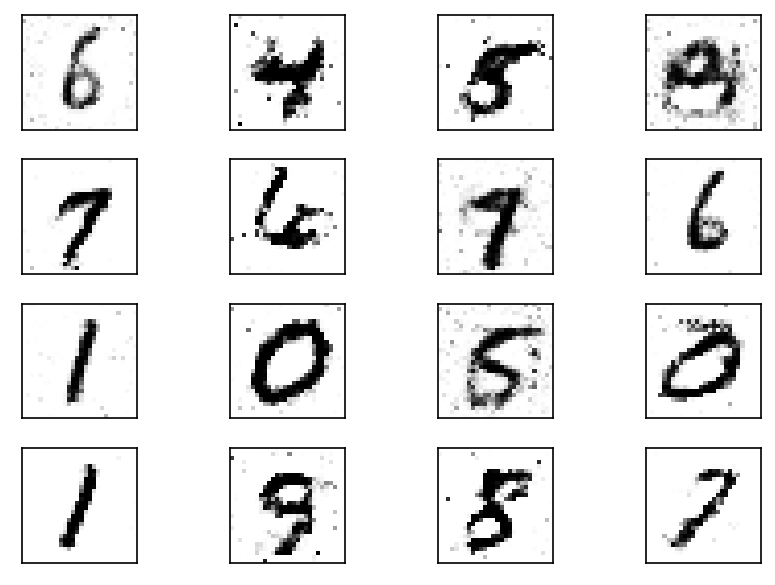

In [16]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)

generated_samples = generator(latent_space_samples)
generated_samples = generated_samples.cpu().detach()

plt.figure(dpi=150)
for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

In [17]:
# Save trained NN parameters
torch.save(generator.state_dict(), 'generator.pt')
torch.save(discriminator.state_dict(), 'discriminator.pt')